# Analysis of Exchange Pattern

In [1]:
import pandas as pd
import pickle
import numpy as np

## 1. Load the Reddit Data
paris_dense is the confirmed transaction data with time from Rappaz et. al (2017).

In [2]:
pair_time = pd.read_csv('data/pairs_dense.csv',names=['user1','game1','user2','game2','time'])
pair_time['time'] = pd.to_datetime(pair_time['time'],unit='s')

In [3]:
pair_time.loc[pair_time['time']<'1970-01-01']

,user1,game1,user2,game2,time
588,13866,590,3357,461,1969-12-31 23:59:59
730,9752,1785,604,1183,1969-12-31 23:59:59


We can see that the exchange data starts from 2013-10-01 to 2015-09-22.

In [4]:
pair_time[pair_time['time']>='2000-01-01'].time.describe(datetime_is_numeric=True)

count                             2096
mean     2014-04-28 05:21:50.124045824
min                2013-10-01 19:51:32
25%                2013-11-05 03:47:58
50%                2014-01-27 19:25:24
75%                2014-09-14 02:22:07
max                2015-09-22 22:06:52
Name: time, dtype: object

In [5]:
def get_relationship(pair, games_genres):
    # Join the pair and games_genres on game1
    pair_genres = pair.join(games_genres.set_index('game_id'), on='game1')

    # Join the pair_genres and games_genres on game2
    pair_genres = pair_genres.join(games_genres.set_index('game_id'), on='game2', rsuffix='_2')

    relationship = pair_genres[['genres', 'genres_2']]
    # Drop the rows with NaN
    relationship = relationship.dropna()

    # Transform the columns to list
    relationship['genres'] = relationship['genres'].apply(lambda x: [int(y) for y in x[1:-1].split(',')])
    relationship['genres_2'] = relationship['genres_2'].apply(lambda x: [int(y) for y in x[1:-1].split(',')])


    relationship_explode = relationship.explode(['genres'])
    relationship_explode = relationship_explode.explode(['genres_2'])
    relationship_explode = relationship_explode.groupby(['genres', 'genres_2']).size().reset_index(name='count')

    # If genres_2 is greater than genres, swap them
    relationship_explode['genres'], relationship_explode['genres_2'] = \
        zip(*relationship_explode.apply(lambda x: (x['genres_2'], x['genres']) if x['genres_2'] > x['genres'] else (x['genres'], x['genres_2']), axis=1))

    # Sort the values by genres and genres_2
    relationship_explode = relationship_explode.sort_values(by=['genres', 'genres_2'])

    # Group by genres and genres_2 and sum the count
    relationship_explode = relationship_explode.groupby(['genres', 'genres_2']).sum().reset_index()
    
    return relationship_explode

In [6]:
# Load the gameswap transaction data with col names ['user1','game1','user2','game2']
pair = pd.read_csv('data/pairs.csv', names=['user1','game1','user2','game2'])

# Load have and wish data
have = pd.read_csv('data/have.csv', names=['user','game'])
wish = pd.read_csv('data/wish_dense.csv', names=['user','game'])

# Load the games data we get from IGDB
games = pd.read_csv('data/games_tbp.csv', index_col=0)
# Add a column of index with name 'game_id', second column
games.insert(1, 'game_id', range(0, len(games)))

games_genres = games[['game_id', 'genres']]

relationship_explode = get_relationship(pair, games_genres)

In [19]:
# Outer join have and wish on user
have_wish = have.merge(wish, on='user', how='outer', suffixes=['1','2']).astype('Int64')
display(have_wish.head(10))
print(have_wish.shape)

In [32]:
print("#Rows that people don't list what they have:", have_wish.loc[have_wish['game1'].isnull()].shape[0])
print("#Rows that people don't list what they wish:", have_wish.loc[have_wish['game2'].isnull()].shape[0])

#Rows that people don't list what they have: 4039
#Rows that people don't list what they wish: 4070


In [33]:
have_wish_cleaned = have_wish.dropna()

In [34]:
have_wish_relationship = get_relationship(have_wish_cleaned, games_genres)

In [35]:
have_wish_relationship

,genres,genres_2,count
0,2,2,23
1,4,2,100
2,4,4,1133
3,5,2,725
4,5,4,8659
...,...,...,...
266,36,25,23
267,36,31,125
268,36,32,36
269,36,33,8


## 2. Plot the relationship
The detailed information about the games is obtained using IGDB.


In [37]:
with open('data/genres_igdb.pickle','rb') as f:
    genres_names = pickle.load(f)[['id','name']]
genres_names.T

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
id,4,5,7,8,9,10,11,12,13,14,...,26,25,30,31,33,34,32,35,36,2
name,Fighting,Shooter,Music,Platform,Puzzle,Racing,Real Time Strategy (RTS),Role-playing (RPG),Simulator,Sport,...,Quiz/Trivia,Hack and slash/Beat 'em up,Pinball,Adventure,Arcade,Visual Novel,Indie,Card & Board Game,MOBA,Point-and-click


In [38]:
def relationship_with_name(relationship_explode, genres_names):
    df = pd.merge(relationship_explode, genres_names, left_on='genres',right_on='id')
    relationship_genres = pd.merge(df, genres_names, left_on='genres_2',right_on='id',suffixes=['_1','_2'])[['name_1','name_2','count']]
    relationship_syn = relationship_genres.pivot('name_1','name_2','count')

    # Make the relationship symmetric without changing the diagonal
    relationship_syn = relationship_syn.fillna(0) + relationship_syn.T.fillna(0)

    # Divide the diagonal by 2
    np.fill_diagonal(relationship_syn.values, relationship_syn.values.diagonal()/2)

    # Delete the rows and columns with all NaN
    relationship_syn = relationship_syn.dropna(axis=0, how='all')
    relationship_syn = relationship_syn.dropna(axis=1, how='all')

    return relationship_syn

In [94]:
# Plot the relationship between genres
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_relationship(relationship_explode, figure_name, genres_names=genres_names, processed=False):
    if not processed:
        relationship_syn = relationship_with_name(relationship_explode, genres_names)
    else:
        relationship_syn = relationship_explode
    # Set the figure size
    plt.figure(figsize=(20,20))
    # Plot the relationship_genres symmetrically
    # Annotate the heatmap with the count, not scientific notation
    ax = sns.heatmap(relationship_syn, annot=True, fmt='g', cmap='Blues')
    # Set the title
    plt.title('Relationship between genres')
    # Set the x-axis label
    plt.xlabel('Genres')
    # Let the x-axis in the upper side
    ax.xaxis.tick_top()
    # Rotate the x-axis label
    plt.xticks(rotation=45, ha='left')
    # Set the y-axis label
    plt.ylabel('Genres')
    plt.yticks(rotation=0)
    # Save the figure
    plt.savefig('plot/relationship_%s.png'%figure_name, dpi=300)
    plt.show()

/tmp/ipykernel_4978/2701385961.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


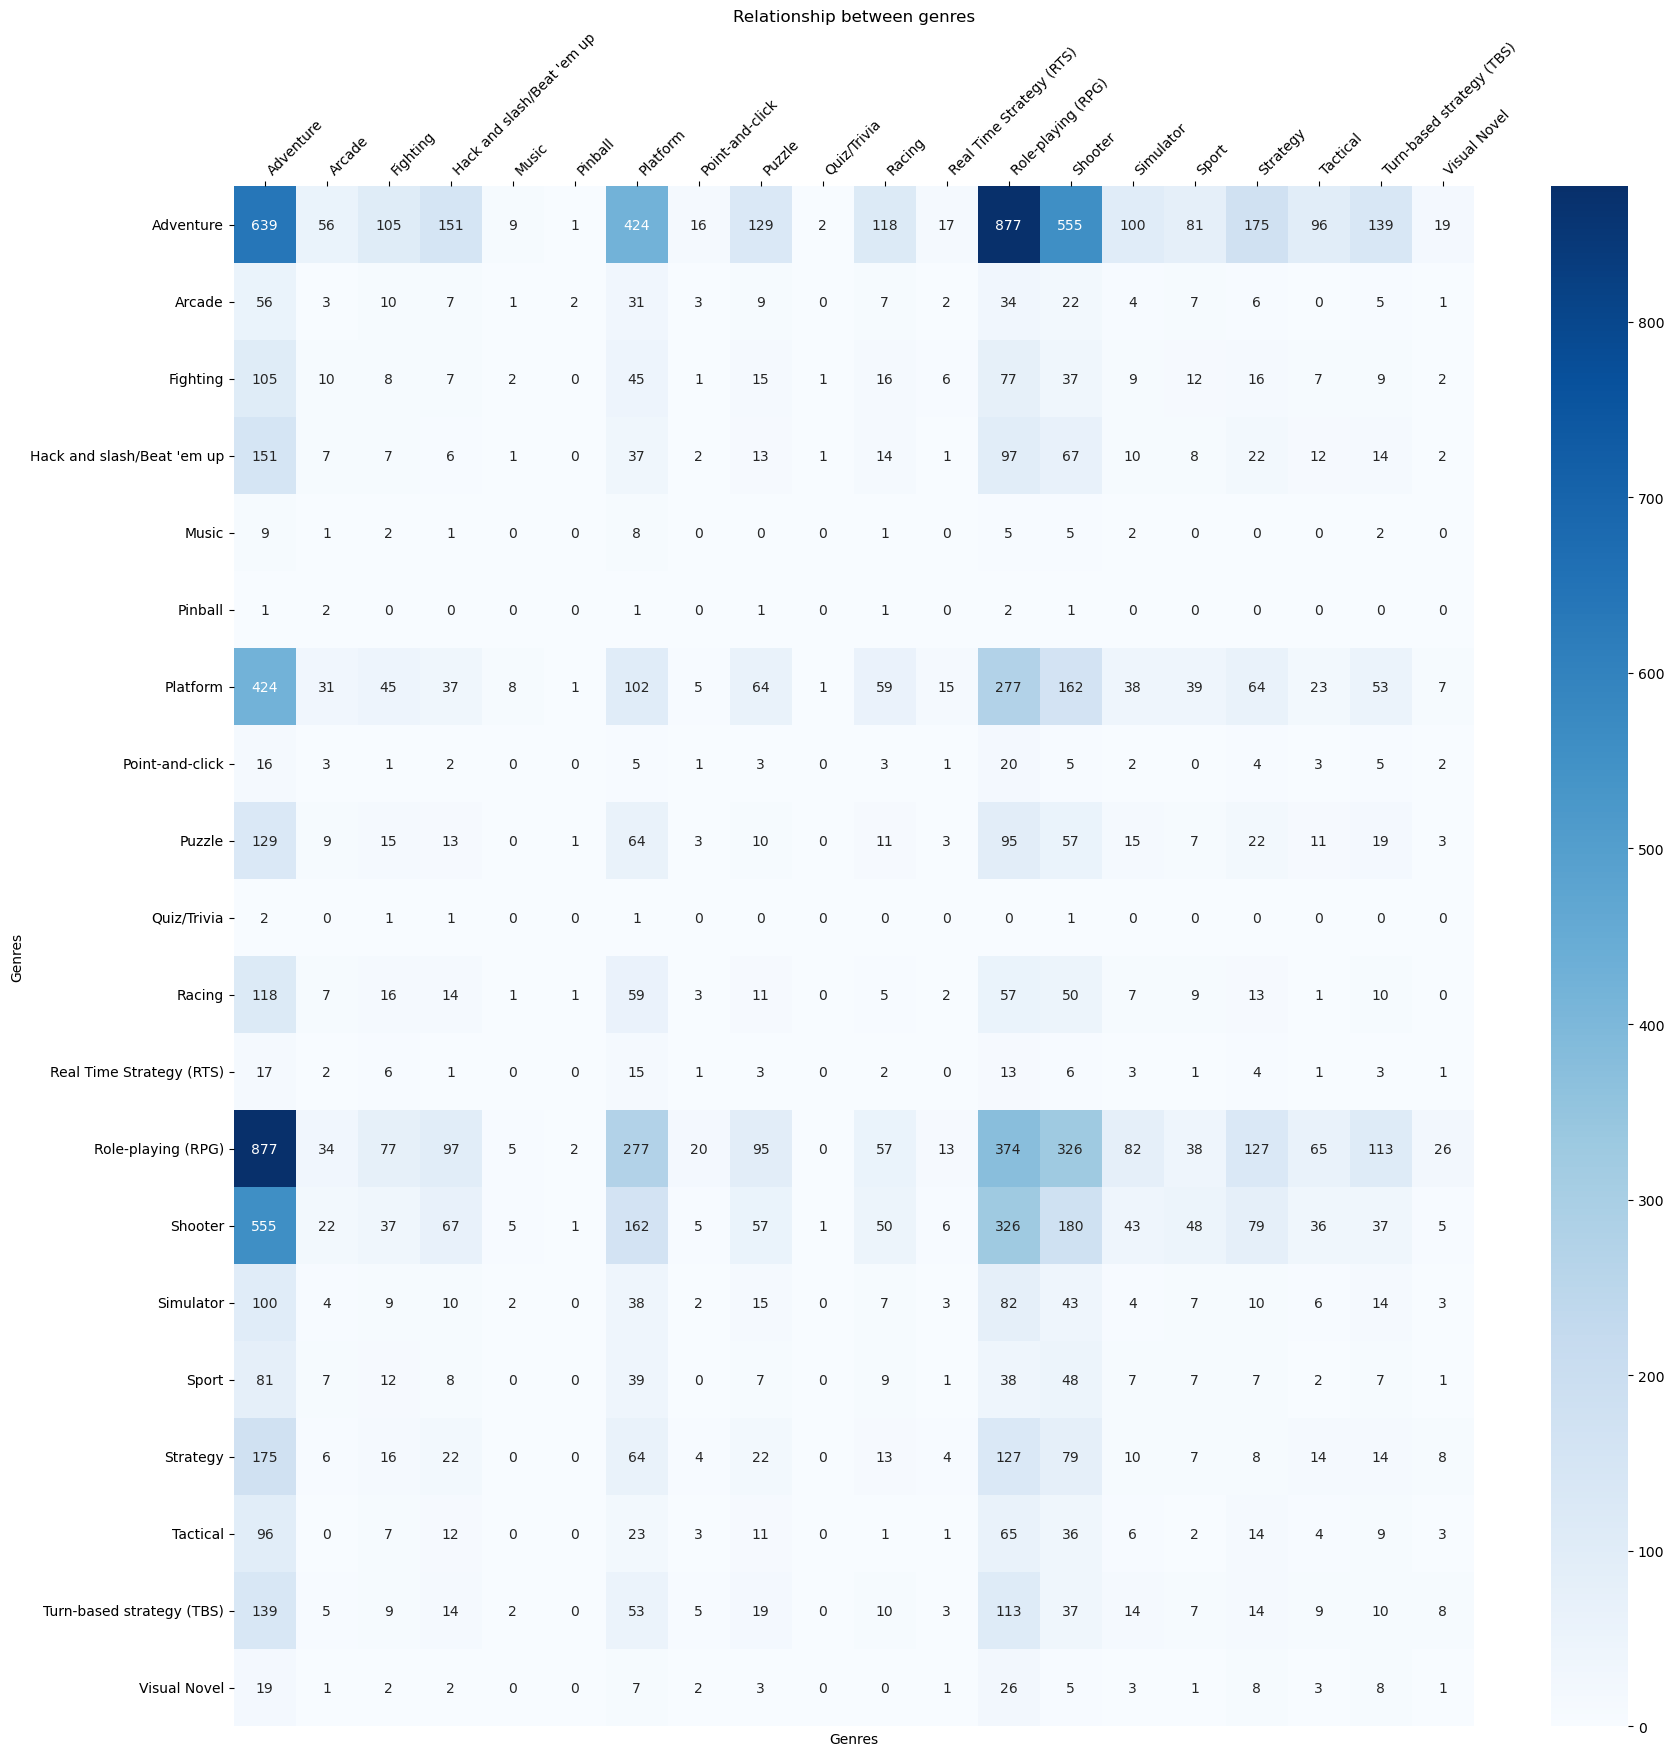

In [45]:
plot_relationship(relationship_explode, 'confirmed')

/tmp/ipykernel_4978/2701385961.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


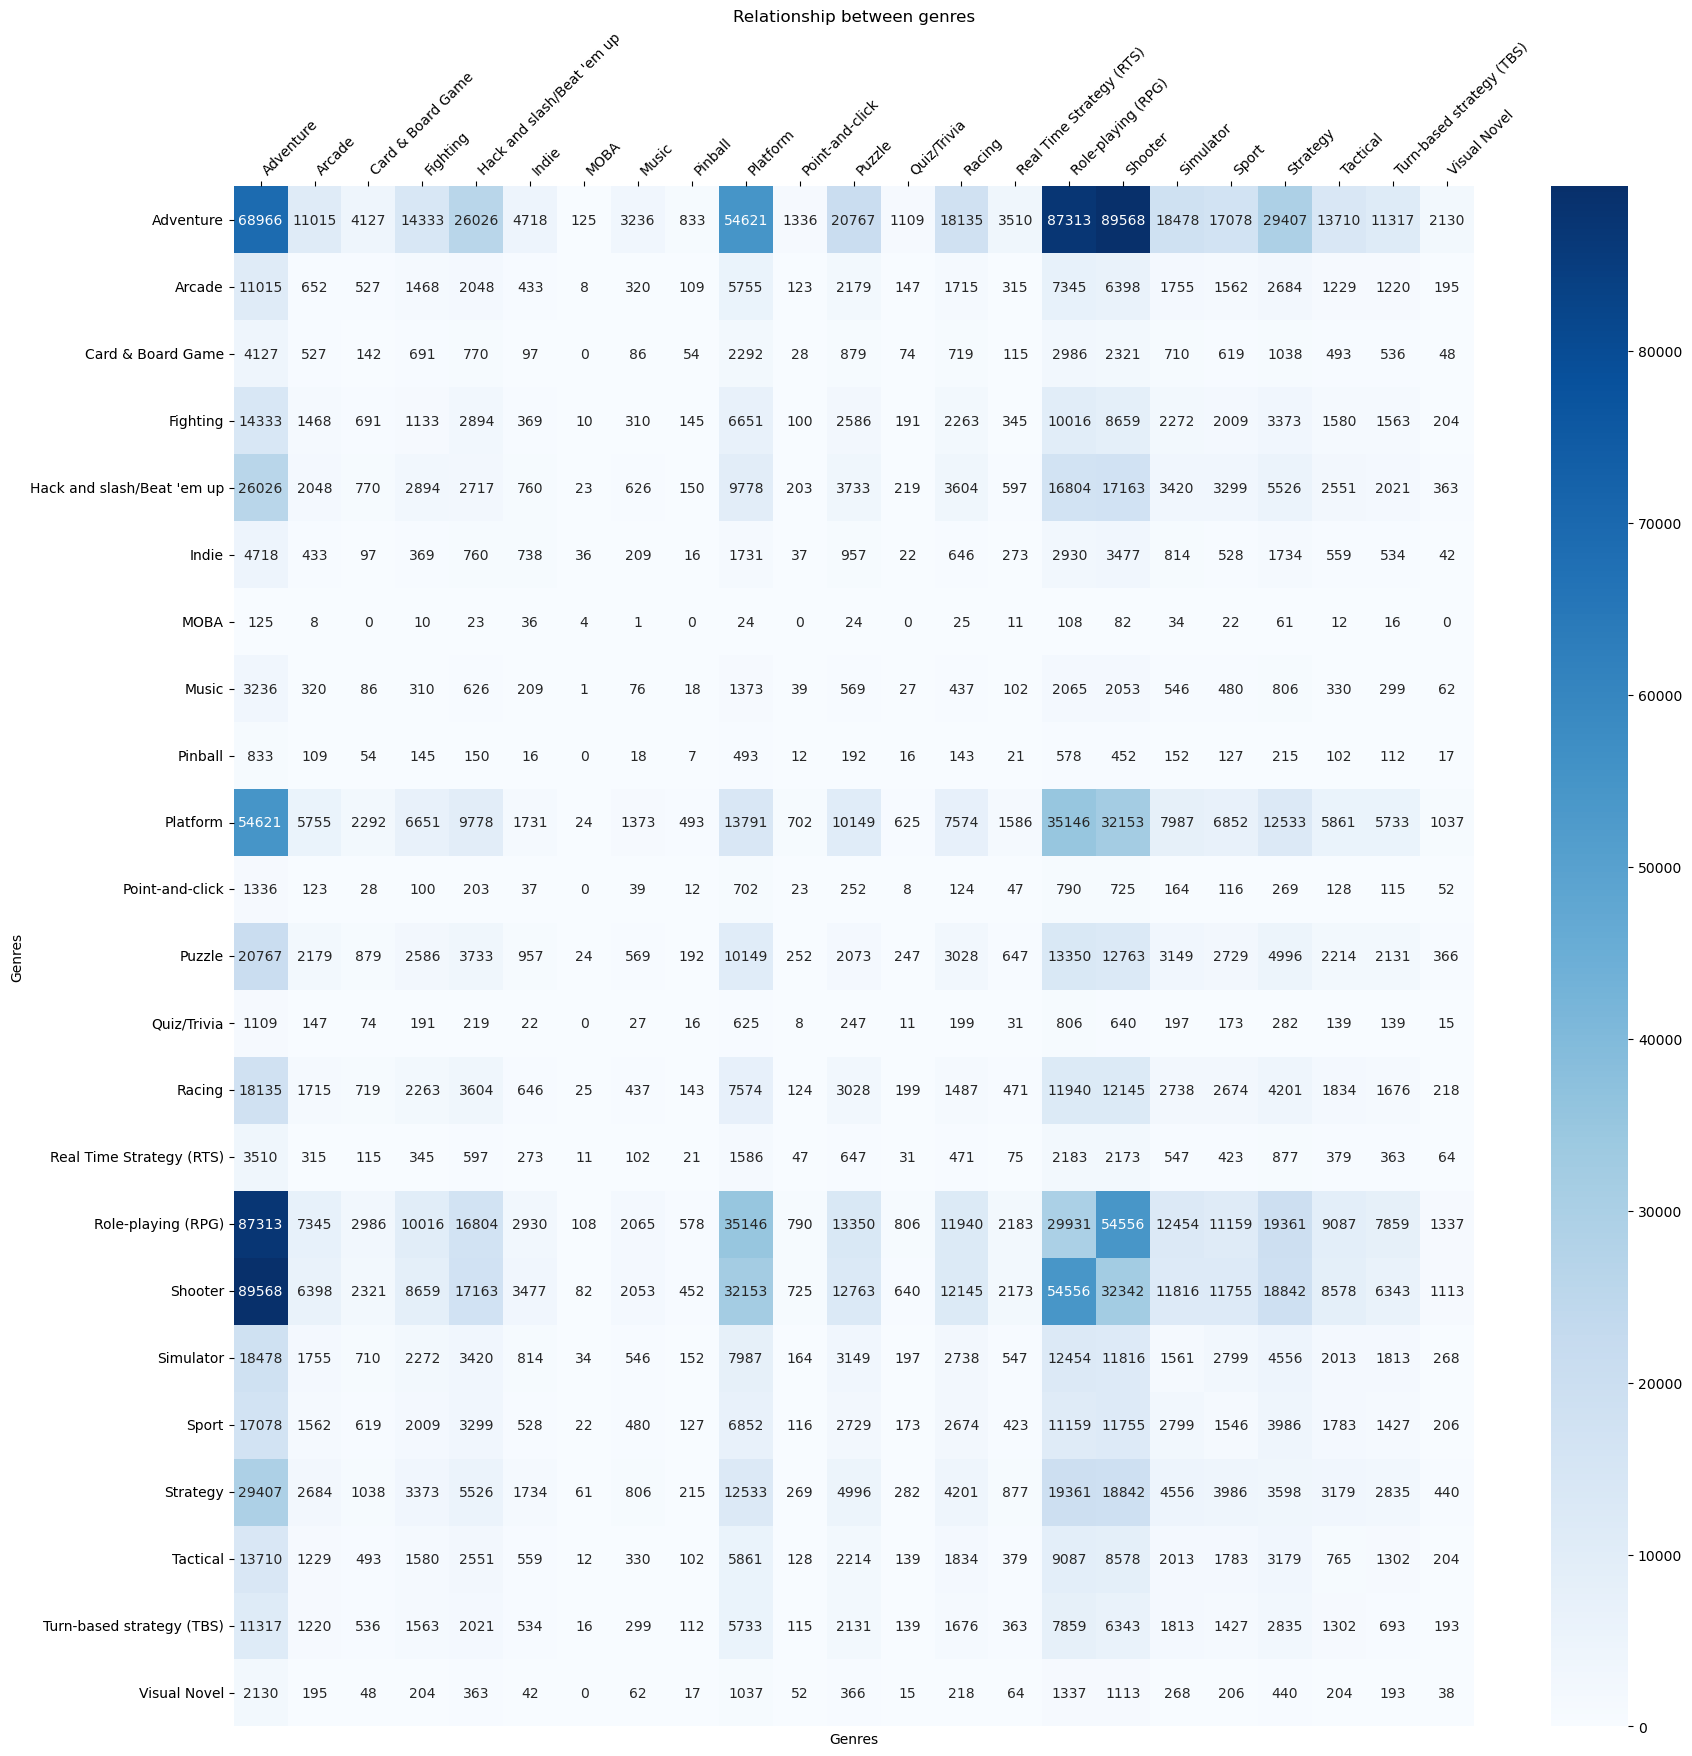

In [46]:
plot_relationship(have_wish_relationship, 'have_wish')

In [100]:
relationship_confirmed = relationship_with_name(relationship_explode, genres_names)
relationship_have_wish = relationship_with_name(have_wish_relationship, genres_names)

genres_confirmed = relationship_confirmed.columns
genres_have_wish = relationship_have_wish.columns

# Expand the relationship_confirmed and relationship_have_wish to the same size
relationship_confirmed = relationship_confirmed.reindex(index=relationship_have_wish.index, columns=relationship_have_wish.columns, fill_value=0)

# Normalize the relationship_confirmed and relationship_have_wish, they are symmetric
relationship_confirmed_norm = relationship_confirmed / relationship_confirmed.sum(axis=1)
for i in range(relationship_confirmed_norm.shape[0]):
    relationship_confirmed_norm.iloc[i,:] = relationship_confirmed_norm.iloc[:,i] 
relationship_confirmed_norm.fillna(0, inplace=True)

relationship_have_wish_norm = relationship_have_wish / relationship_have_wish.sum(axis=1)
for i in range(relationship_have_wish_norm.shape[0]):
    relationship_have_wish_norm.iloc[i,:] = relationship_have_wish_norm.iloc[:,i]
relationship_have_wish_norm.fillna(0, inplace=True)

# Calculate the difference between relationship_confirmed and relationship_have_wish
relationship_diff = relationship_have_wish_norm - relationship_confirmed_norm

# Transform the dataframe to be better for plotting.
relationship_diff_plot = relationship_diff.copy()
relationship_diff_plot = 100 * relationship_diff_plot
relationship_diff_plot = relationship_diff_plot.round(2)

/tmp/ipykernel_4978/2701385961.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')
/tmp/ipykernel_4978/2701385961.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  relationship_syn = relationship_genres.pivot('name_1','name_2','count')


In [103]:
 # Games only in have_wish but not in confirmed exchange.
 set(genres_have_wish) - set(genres_confirmed)

{'Card & Board Game', 'Indie', 'MOBA'}

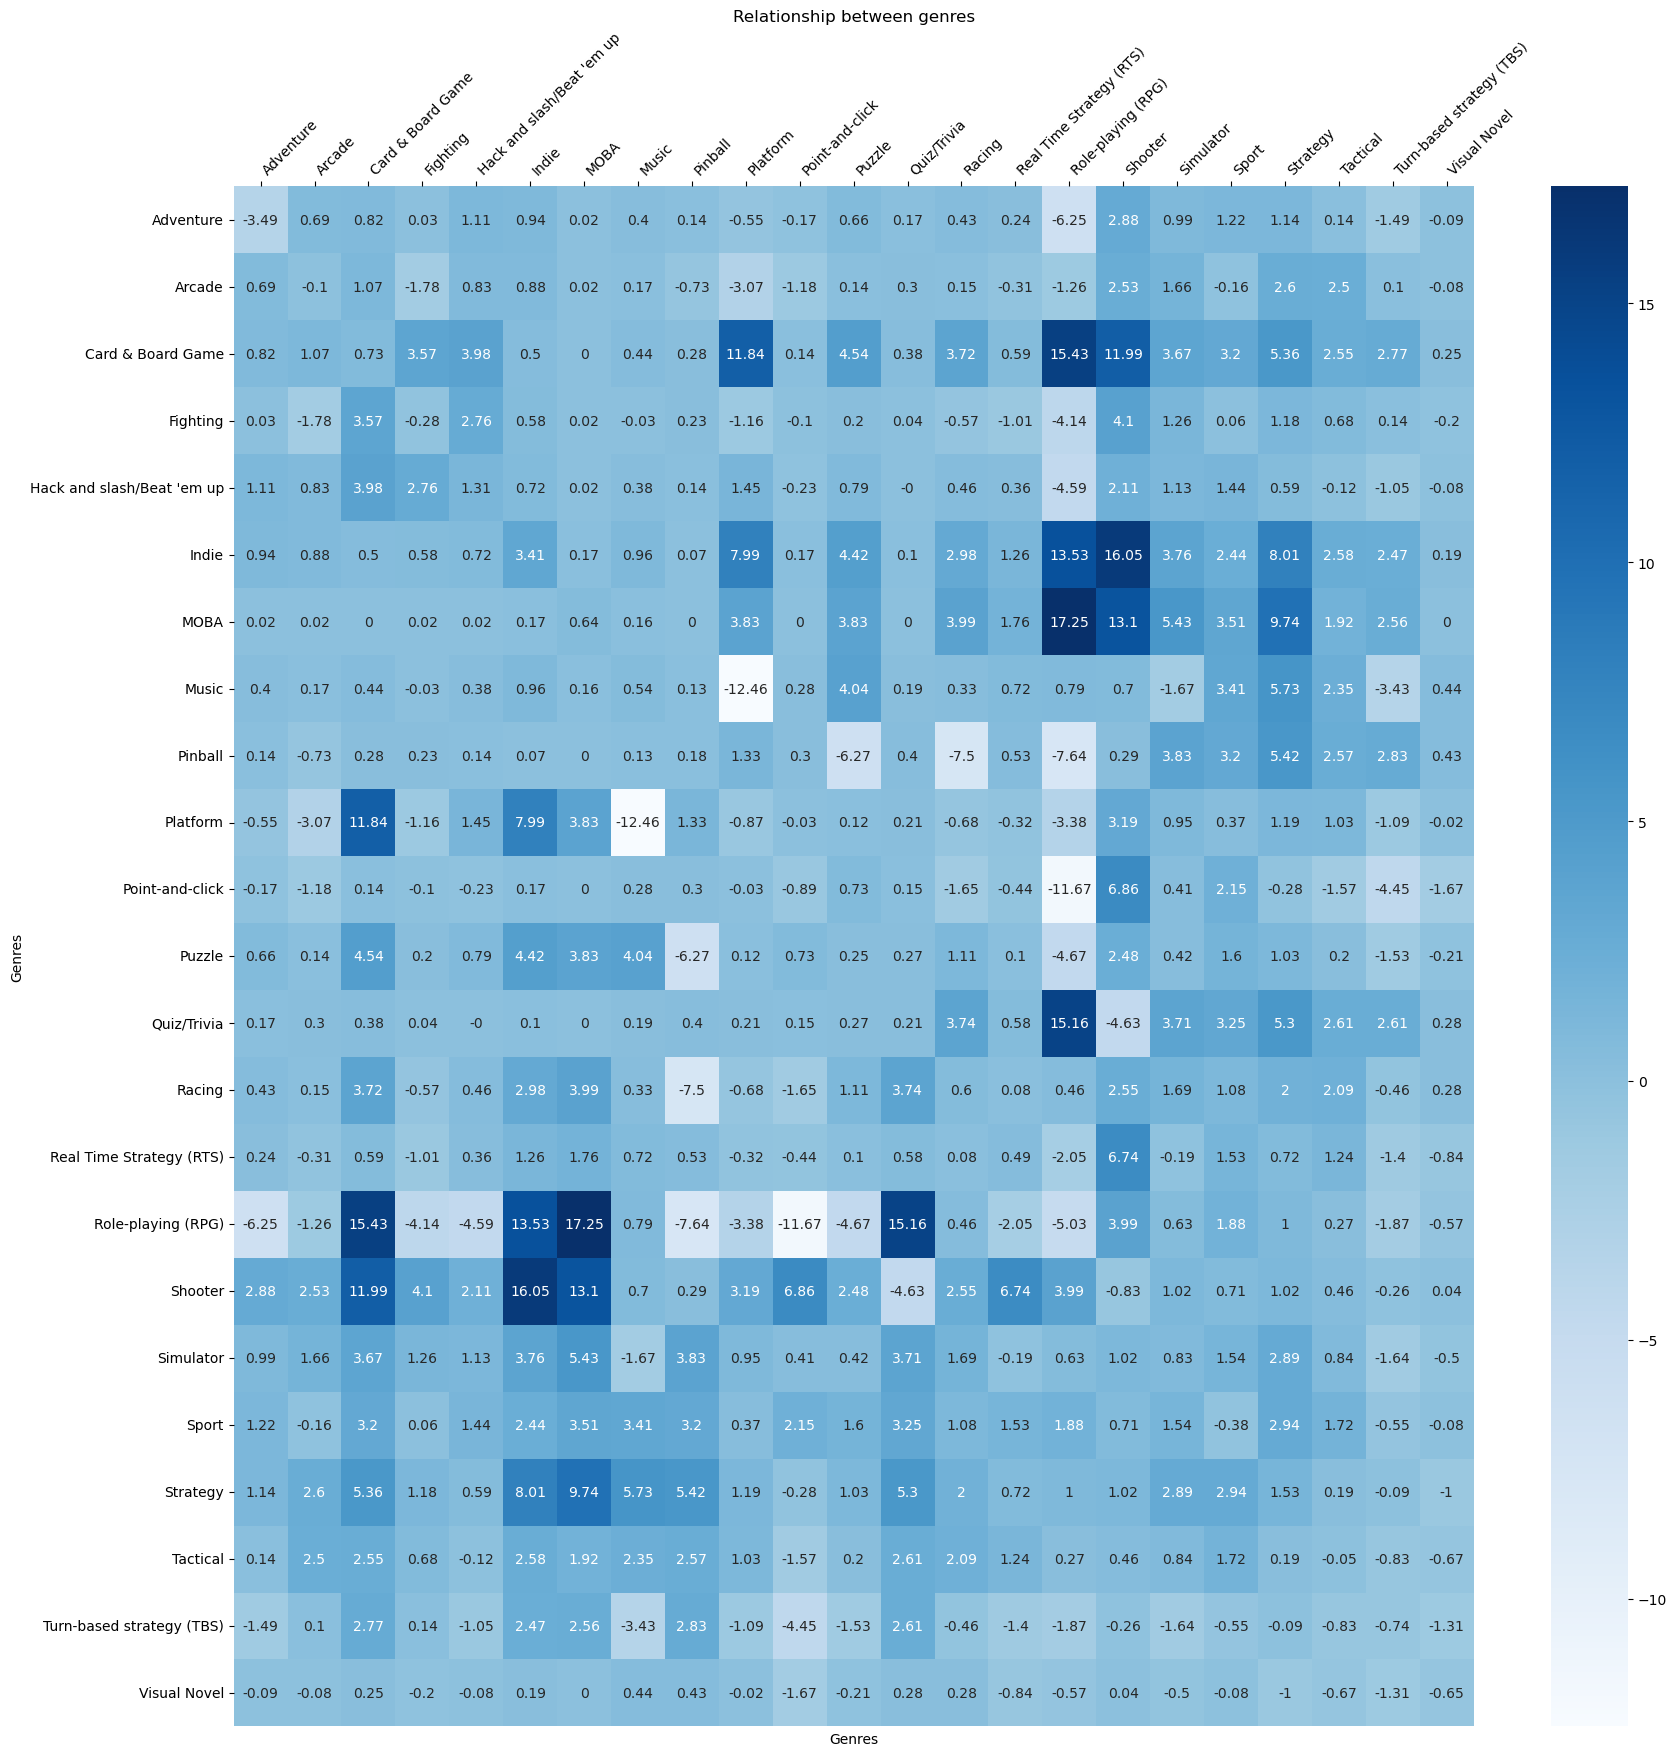

In [99]:
plot_relationship(relationship_diff_plot, 'diff', processed=True)